In [1]:
## read json
!pip install rdflib
import rdflib,pandas,json,os
from rdflib import URIRef, Literal, BNode, Namespace, RDF
from google.colab import drive
drive.mount('/content/drive')

rootPath = '/content/drive/MyDrive/UCLA REU 2021 KG /results/'
def fullPath(filename):
  return os.path.join(os.path.dirname(rootPath), filename) # rootPath+filename


#with open(fullPath('Mar01-Apr16/document_data_mar01-apr16.json')) as file:
with open(fullPath('2020Mar11-2021June16/processed_tweets_20mar11-21june16.json')) as file:
  jsons = json.load(file)

with open(fullPath('2020Mar11-2021June16/user_data_20mar11-21june16.json')) as file:
  user_data = json.load(file)

print(jsons[0]["text"])
print(user_data[0])

     |████████████████████████████████| 376 kB 5.0 MB/s 
     |████████████████████████████████| 45 kB 3.1 MB/s 
Mounted at /content/drive


FileNotFoundError: ignored

In [3]:
# create triples
from collections import namedtuple

Triple = namedtuple("Triple", "subj pred obj")
triples = []

def createTriples(r, s, o): # for each json object x, it adds an edge from x[s] to x[o] with relation r.
  for i in range(0,len(jsons)):
    x = jsons[i]
    if (s in x) and (x[s]):
      if (o in x) and (x[o] != []) and x[o] != {} and x[o] != None:
        if (o == "sentiment_dict"):
          triples.append(Triple(subj=x[s],pred=r,obj=list(x[o].keys())))
        else:
          triples.append(Triple(subj=x[s],pred=r,obj=x[o]))
  """
  for i in range(0,len(user_data)):
    x = user_data[i]
    if (s in x) and (x[s]):
      if (o in x) and (x[o]):
        
          triples.append(Triple(subj=x[s],pred=r,obj=x[o]))
  """

createTriples("replied_by","tweet-id","replies")
createTriples("quoted_by","tweet-id","quotes")
createTriples("Tweeted_By","tweet-id","user-id")
createTriples("has_keyword","tweet-id","sentiment_dict") # need to add keyword key and its value in the sample database dictionary
createTriples("sentimentScore","tweet-id","vadar_sentiment")
createTriples("sentimentScore","tweet-id","sentiment_score")
createTriples("Topic","tweet-id","LDA_topic")
createTriples("timestamp","tweet-id","timestamp")
#createTriples("screen_name","user-id","user-screen_name")

print(triples[0])
# for i in range(0,len(jsons)):
#   x = jsons[i]
#   triples.append(Triple(subj=x["id"],pred="Tweeted_by",obj=x["user"]["id"]))

Triple(subj=1237638024000724992, pred='replied_by', obj=['1237638905622487040'])


In [ ]:
for i in user_data:
  if (str(i["tweet-id"]) == "1249747787710730240"):
    print(i)


{'tweet-id': 1249747787710730240, 'user-id': 3236388377, 'user-screen_name': 'misthiOSX', 'verified': False, 'followers-count': 6332}


In [9]:

#add triples to graph, construct the graph using data from document_data.json
def add_triple_to_graph(triple, G):
    
    subject = rdflib.Literal(str(triple.subj))

    v2 = triple.obj
    relation = rdflib.URIRef(nmsp + triple.pred)
    if (type(v2) == list): #tweet has (a list of) keyword(s) XXX
        for word in v2:
            object = rdflib.Literal( str(word))
            G.add((subject, relation, object))
    else: # relations between tweets
        object = rdflib.Literal(str(v2))
        G.add((subject,relation,object))
        
    return #(nmsp[(triple.subj)],nmsp[str(triple.pred)],nmsp[(triple.obj)])

def convert_to_list_of_answer(query_answer):
    """
    convert answers we get from query to string values stored in a list
    """
    answer = []
    for a in query_answer:
        sub =[]
        for i in a:
            token = str(i).split('/')[-1]
            sub.append(token)
        answer.append(sub)
    return answer






# construct graph from dataset

nmsp = Namespace("http://UCLA_REU_2021_KG.org/test/")
graph = rdflib.Graph()

#add triples to the graph
for i in triples:
    add_triple_to_graph(i, graph)



In [ ]:
obj_lst=[]
for triple in triples:
  obj_lst.append(triple[2])
print(obj_lst)

[['1240897411737763846'], ['1240900224882601984'], ['1240900556136144897'], ['1240900558078103552'], ['1240900561655848960'], ['1240901097423691776'], ['1240902519280156672'], ['1240904089195565056'], ['1240906257017397249'], ['1240911193260175360'], ['1240919596170797058'], ['1240920013789253632'], ['1240929598830858240'], ['1241076717940142080'], ['1240936194994651137'], ['1240940704349556738'], ['1240950148139585536'], ['1240986633182121986'], ['1241040120934838273'], ['1240978014466260993'], ['1241005446242041856', '1241053436663099393'], ['1241002583679877120'], ['1241112251722944515'], ['1241020506360279040'], ['1241012994663825410'], ['1241016273699405826'], ['1241016949686951937'], ['1241021359871766529'], ['1241055291363348481'], ['1241018848742002689'], ['1241019917605855232'], ['1241021389609418754'], ['1241031879874064384'], ['1241025928173477891'], ['1241028539673018370'], ['1241114123699539968'], ['1241029994031149056'], ['1241034500001239041'], ['1241034956890984449'], [

In [ ]:
#make files to run through OpenKE
#list unique nodes
q = " SELECT DISTINCT ?s WHERE {?s ?p ?o}"
x = graph.query(q)
subjects_list = convert_to_list_of_answer(x)
subjects_list = [item for sublist in subjects_list for item in sublist]

q = " SELECT DISTINCT ?o WHERE {?s ?p ?o}"
x = graph.query(q)
objects_list = convert_to_list_of_answer(x)
new_objects_list = []
for sublist in objects_list:
  if isinstance(sublist, list):
    for item in sublist:
      new_objects_list.append(item)
  else:
    new_objects_list.append(sublist)
nodes_list=list(set(subjects_list).union(set(new_objects_list)))
nodes_dict={k: v for v, k in enumerate(nodes_list)}
entities_file=open("/content/drive/MyDrive/UCLA REU 2021 KG /results/entity2id.txt", "w")
entities_file.write(str(len(nodes_list))+"\n")
for n in nodes_list:
  entities_file.write(str(n)+"\t"+str(nodes_dict[n])+"\n")
entities_file.close()

#list unique relations
q = " SELECT DISTINCT ?p WHERE {?s ?p ?o}"
x = graph.query(q)
relations_list = convert_to_list_of_answer(x)
relations_list = [item for sublist in relations_list for item in sublist]
relations_dict={k: v for v, k in enumerate(relations_list)}
relations_file=open("/content/drive/MyDrive/UCLA REU 2021 KG /results/relation2id.txt", "w")
relations_file.write(str(len(relations_list))+"\n")
for r in relations_list:
  relations_file.write(str(r)+"\t"+str(relations_dict[r])+"\n")
relations_file.close()

#list of triples
triples_file=open("/content/drive/MyDrive/UCLA REU 2021 KG /results/train2id.txt", "w")
triples_file.write(str(len(triples))+"\n")
for triple in triples:
  if isinstance(triple[2], list):
    triples_file.write(str(nodes_dict[str(triple[0])]) +"\t"+str(nodes_dict[str(triple[2][0])])+"\t"+str(relations_dict[str(triple[1])])+"\n")
  else: 
    triples_file.write(str(nodes_dict[str(triple[0])]) +"\t"+str(nodes_dict[str(triple[2])])+"\t"+str(relations_dict[str(triple[1])])+"\n")
triples_file.close()

[['705872950444986368'], ['Fri Mar 20 20:17:06 +0000 2020'], ['0'], ['783446414692974592'], ['4890233816'], ['522035453'], ['961576278'], ['0.4767'], ['center'], ['Mon Mar 23 17:34:55 +0000 2020'], ['4228252965'], ['chase'], ['1079120511756468225'], ['17450881'], ['980434601981050891'], ['4341082166'], ['18751096'], ['louis'], ['happen'], ['1022990064312360960'], ['impeachedforever'], ['26646143'], ['1239152652002328576'], ['draft'], ['0.6808'], ['nonstop'], ['0.4588'], ['775523078927360000'], ['1393840489'], ['108813540'], ['31702569'], ['Mon Mar 23 23:18:18 +0000 2020'], ['1571929249'], ['272626286'], ['quarantine'], ['2218534980'], ['announce'], ['2521171'], ['1240534116614852608'], ['1039966449597538304'], ['-0.3182'], ['0.5526'], ['162586979'], ['3035381818'], ['dallas'], ['90806148'], ['281382916'], ['maybe'], ['52335566'], ['Sat Mar 21 17:19:21 +0000 2020'], ['760277814658465792'], ['1002948543613624320'], ['-0.5574'], ['339288620'], ['Mon Mar 23 10:35:33 +0000 2020'], ['1151367

In [13]:
n = 0
for (a,b,c) in graph:
  if 20000<n < 22000:
    print(a,b,c)
  n+=1

1385612779042734080 http://UCLA_REU_2021_KG.org/test/timestamp Fri Apr 23 15:13:24 +0000 2021
1239418752975785984 http://UCLA_REU_2021_KG.org/test/Tweeted_By 409037467
1238338960008466432 http://UCLA_REU_2021_KG.org/test/timestamp Fri Mar 13 05:39:49 +0000 2020
1283095988278714368 http://UCLA_REU_2021_KG.org/test/timestamp Tue Jul 14 17:48:17 +0000 2020
1317967227589586944 http://UCLA_REU_2021_KG.org/test/Tweeted_By 1329994814
1244473974811054080 http://UCLA_REU_2021_KG.org/test/timestamp Mon Mar 30 03:58:11 +0000 2020
1266493877864689664 http://UCLA_REU_2021_KG.org/test/Tweeted_By 176465009
1259212838591033344 http://UCLA_REU_2021_KG.org/test/replied_by 1259212848569307138
1248648362397782016 http://UCLA_REU_2021_KG.org/test/Tweeted_By 275190173
1286197139987501056 http://UCLA_REU_2021_KG.org/test/Tweeted_By 88551535
1240882743300374528 http://UCLA_REU_2021_KG.org/test/Tweeted_By 33410250
1238730703891615744 http://UCLA_REU_2021_KG.org/test/Tweeted_By 803743428559286272
12614051120832

In [10]:
#Different kinds of graph queries

"""
Note, mayor tweet is missing in our dataset
"""

#In this first query we are selecting every variable in the pattern 
#so we can represent that with a * character. 
print("First 10 triples in the graph:")
q = " SELECT * WHERE {?s ?p ?o .} limit 10"
x = graph.query(q)
print("answer:  ",list(x),'\n')
print("answer converted to string: ",convert_to_list_of_answer(x),'\n')

q = " SELECT ?p ?o WHERE {'1239446307845967872' ?p ?o .}"
x = graph.query(q)

print("1239446307845967872, answer converted to string: ",convert_to_list_of_answer(x),'\n')


#find tweets that have keyword safe
print('find tweets that have keyword safe')
#PREFIX ns: <http://UCLA_REU_2021_KG.org/test/>
q = """  
       select ?tweet  where { ?tweet <http://UCLA_REU_2021_KG.org/test/has_keyword> "safe" }"""
x = graph.query(q)
print(convert_to_list_of_answer(x),'\n')


#find tweets are In_Reply_To the mayor tweet 1243623427186946048
print('find tweets are In_Reply_To the mayor tweet')
q = "select ?tweet  where { '1243623427186946048' <http://UCLA_REU_2021_KG.org/test/replied_by> ?tweet  }"
x = graph.query(q)
print(convert_to_list_of_answer(x),'\n')

#find keywords of tweet 1243623427186946048(the mayor tweet), and filter out safety, health
print('find keywords of tweet 1243623427186946048(the mayor tweet)')
q = "SELECT ?keywords  WHERE { '1243623427186946048'  <http://UCLA_REU_2021_KG.org/test/has_keyword> ?keywords.\
                               FILTER(str(?keywords) != 'safety').\
                               FILTER(str(?keywords) != 'health')}"
x = graph.query(q)
print("keywords", list(x))
print("convert to string ", convert_to_list_of_answer(x),'\n')


#find tweet IDs such that the tweet has keyword safety(not case sensitive) and the tweet ID 
print('find tweet IDs such that the tweet has keyword safety(not case sensitive) and the tweet ID ')
q = "SELECT ?ID ?Keywords WHERE { ?ID  <http://UCLA_REU_2021_KG.org/test/has_keyword> ?Keywords.\
FILTER(regex(str(?Keywords),'SAFety','i' )).\
FILTER(?ID > 1243623427186946048 )}"
x = graph.query(q)
print("(ID,keyword) ", list(x))
print(convert_to_list_of_answer(x),'\n')


#find keywords of tweet 1243623427186946048(the mayor tweet) With LIMIT 2
print('find keywords of tweet 1243623427186946048(the mayor tweet) with LIMIT 2')
q = "select ?keywords  where { '1243623427186946048'  <http://UCLA_REU_2021_KG.org/test/has_keyword> ?keywords}LIMIT 2"
x = graph.query(q)
print(convert_to_list_of_answer(x),'\n')



#find tweets that have keyword road
print('find tweets that have the keyword road')
q = "select ?tweet  where { ?tweet <http://UCLA_REU_2021_KG.org/test/has_keyword>  'road' }"
x = graph.query(q)
print(convert_to_list_of_answer(x),'\n')

#find tweet1 and tweet2 such that tweet1 quotes from tweet2
print('find tweet1 and tweet2 such that tweet1 quotes from tweet2')
q = "select ?tweet1 ?tweet2  where { ?tweet1 <http://UCLA_REU_2021_KG.org/test/quoted_by>  ?tweet2}"
x = graph.query(q)
#print(list(x))
print(convert_to_list_of_answer(x),'\n')

#find tweets such that it has keyword safe and sad
print('find tweets such that it has keyword safe and sad')
q = "select ?tweet where { ?tweet <http://UCLA_REU_2021_KG.org/test/has_keyword> 'safe', 'sad' }"
x = graph.query(q)
#print(list(x))
print(convert_to_list_of_answer(x),'\n')

print('find tweets a and b such that a is in reply to b and a b has same keyword ')
x = graph.query(
    """SELECT DISTINCT ?a ?b ?keyword
       WHERE {
          ?a <http://UCLA_REU_2021_KG.org/test/replied_by> ?b .
          ?b <http://UCLA_REU_2021_KG.org/test/has_keyword> ?keyword .
          ?a <http://UCLA_REU_2021_KG.org/test/has_keyword> ?keyword.
       }""")
print(convert_to_list_of_answer(x),'\n')

#find tweets that have at least one same keyword with tweet 1243623427186946048(the mayor tweet) 
print('find tweets that have at least one keyword in common with tweet 1243623427186946048(the mayor tweet) ')
q = "select ?keywords ?tweet where { '1243623427186946048'  <http://UCLA_REU_2021_KG.org/test/has_keyword> ?keywords.\
                                      ?tweet <http://UCLA_REU_2021_KG.org/test/has_keyword> ?keywords.\
                                      FILTER((?tweet) != '1243623427186946048')}"
x = graph.query(q)
print(convert_to_list_of_answer(x),'\n')

#find how many keywords each tweet has
print("find how many keywords each tweet has")
q = """SELECT ?tweet (COUNT(?val) AS ?count)
WHERE {
  ?tweet <http://UCLA_REU_2021_KG.org/test/has_keyword> ?val .
} GROUP BY ?tweet"""
x = graph.query(q)
#print(list(x))
print(convert_to_list_of_answer(x),'\n')

First 10 triples in the graph:
answer:   [(rdflib.term.URIRef('http://UCLA_REU_2021_KG.org/test/timestamp'), rdflib.term.Literal('Fri Jul 31 17:33:43 +0000 2020'), rdflib.term.Literal('1289252917573165056')), (rdflib.term.URIRef('http://UCLA_REU_2021_KG.org/test/timestamp'), rdflib.term.Literal('Tue Jul 14 22:04:25 +0000 2020'), rdflib.term.Literal('1283160447953313792')), (rdflib.term.URIRef('http://UCLA_REU_2021_KG.org/test/timestamp'), rdflib.term.Literal('Wed Oct 07 20:12:50 +0000 2020'), rdflib.term.Literal('1313935334363725824')), (rdflib.term.URIRef('http://UCLA_REU_2021_KG.org/test/replied_by'), rdflib.term.Literal('1237915962252259328'), rdflib.term.Literal('1237915582680317952')), (rdflib.term.URIRef('http://UCLA_REU_2021_KG.org/test/Tweeted_By'), rdflib.term.Literal('1090278229762437120'), rdflib.term.Literal('1244380240576573440')), (rdflib.term.URIRef('http://UCLA_REU_2021_KG.org/test/Tweeted_By'), rdflib.term.Literal('3258316286'), rdflib.term.Literal('1240856935802404864

In [ ]:
print('find tweets a and b such that a is replied by b and a,b share a same keyword')
x = graph.query(    """SELECT DISTINCT ?a ?b ?keyword       
                       WHERE { ?a <http://UCLA_REU_2021_KG.org/test/replied_by> ?b.        
                       ?b <http://UCLA_REU_2021_KG.org/test/has_keyword> ?keyword.          
                       ?a <http://UCLA_REU_2021_KG.org/test/has_keyword> ?keyword.       } limit 5""")
print(convert_to_list_of_answer(x),'\n')


find tweets a and b such that a is replied by b and a,b share a same keyword
[['1240045043341086720', '1240047853327626240', 'kodie'], ['1243412692322246656', '1243412693735751680', 'strategist'], ['1240532458677796864', '1240532463593508864', 'grama'], ['1246917993696641024', '1246930728736047104', 'nailingitforhealthcareworkers'], ['1242650230882881536', '1242655211404972032', 'quarantine']] 



In [ ]:
# How triples are stored in graph
x = 0
#print first 2000 triples stored in graph
for a,b,c in graph:
  if x < 100:
    print(a,b,c)
    x+=1
    

#for n in graph.namespace_manager.namespaces():
    #print(n)    

1243616224753270784 http://UCLA_REU_2021_KG.org/test/sentimentScore 0.2263
1239983781152305152 http://UCLA_REU_2021_KG.org/test/has_keyword paddy
1243955194439716864 http://UCLA_REU_2021_KG.org/test/has_keyword plenty
1243962212852436992 http://UCLA_REU_2021_KG.org/test/Topic 5
1248687345710194688 http://UCLA_REU_2021_KG.org/test/has_keyword vaccine
1245806503078092800 http://UCLA_REU_2021_KG.org/test/Topic 13
1245032343183560704 http://UCLA_REU_2021_KG.org/test/timestamp Tue Mar 31 16:56:56 +0000 2020
1248487446586654720 http://UCLA_REU_2021_KG.org/test/has_keyword modding
1250616844781682688 http://UCLA_REU_2021_KG.org/test/Topic 12
1244014791993126912 http://UCLA_REU_2021_KG.org/test/has_keyword people
1244145064734908416 http://UCLA_REU_2021_KG.org/test/has_keyword sasquatch
1242904551427989504 http://UCLA_REU_2021_KG.org/test/Topic 18
1250152445638062080 http://UCLA_REU_2021_KG.org/test/has_keyword inventory
1242310730960928768 http://UCLA_REU_2021_KG.org/test/Topic 12
12444761582

In [ ]:
# plot the graph (check the png file saved in the directory of the shared folder)
"""
The knowledge graph is very huge, so we randomly choose some part of it to plot
"""
import matplotlib.pyplot as plt
import networkx as nx

%matplotlib inline
plt.figure(figsize=(100,100))

edgelabels={}
G = nx.Graph()
#plt.clf()

"""
Randomly print 1000 triples in the graph
"""
for i in range(len(triples)):
    triple = triples[i]
    if (triple.pred == "sentimentScore"): continue
    v1 = triple.subj
    v2 = triple.obj

    if (type(v2) == list):
        for word in v2:
            G.add_edge(str(v1),str(word))
            edgelabels[(str(v1),str(word))] = triple.pred
    else:
        G.add_edge(v1,v2)
        edgelabels[(v1, v2)] = triple.pred

   
color_map = []
for node in G:
    if node.isdigit() and len(str(node)) == 19: # distinguish between Tweets (numerical id with length 19) and keywords (string)
      color_map.append('cyan')
    else:
      color_map.append('magenta')
print("total number of nodes: ", len(list(G.nodes())))
layout = nx.spring_layout(G,k=0.15,iterations=20)
# k controls the distance between the nodes and varies between 0 and 1
# iterations is the number of times simulated annealing is run
# default k=0.1 and iterations=50
nx.draw_networkx(G, pos=layout,font_size=2,node_color=color_map,node_size=100)
#nx.draw_networkx_edge_labels(G, pos=layout, edge_labels=edgelabels, font_size=10)

outputFileName = '/content/drive/My Drive/UCLA REU 2021 KG /GraphQuery/graphquery/general_plot3.png'
plt.savefig(outputFileName)
plt.show()

total number of nodes:  115575


In [ ]:

"""
A way of iterating through all nodes in the graph
"""
# print first 10 nodes in the graph


# order the tweets by their popularity (sum of quote_count and replies_count of each tweet)
ordered_list = list(sorted(jsons, key=lambda k: k['quote_count']+ k['replies_count'], reverse=True))
ordered_list_of_tweet_id = list(i['tweet-id'] for i in ordered_list)
#print quote counts and replies count for the first 12 tweets in the ordered list of tweets by popularity
print(list(i['quote_count'] for i in ordered_list[:12]))
print(list(i['replies_count'] for i in ordered_list[:12]))
print('ordered_list', list(ordered_list)[:12])


[113, 32, 27, 20, 33, 0, 0, 26, 25, 25, 16, 3]
[11, 3, 8, 15, 0, 30, 30, 0, 0, 0, 8, 17]
ordered_list [{'tweet-id': 1253831504561504256, 'user-id': 1038138663589167104, 'user-screen_name': 'abc7chriscristi', 'verified': True, 'text': 'RIGHT NOW: This is the scene  from #Air7HD in Newport Beach, CA as the #COVID19 death toll surges in Southern California @ABC7 #LosAngeles https://t.co/Nmta8hU69H', 'cleaned_text': ['right', 'scene', 'newport', 'beach', 'death', 'toll', 'surge', 'southern', 'california'], 'hashtags': {'covid19': 20403}, 'mentions': {}, 'in-reply-to': None, 'quoted': None, 'timestamp': 'Fri Apr 24 23:41:40 +0000 2020', 'followers-count': 1774, 'replies_count': 11, 'quote_count': 113, 'replies': ['1253851983854702592', '1254135469203320832', '1254141317665263616', '1254143008397619201', '1254178636413825024', '1254185074976686081', '1254190909219983360', '1254205303949672448', '1254205552495755264', '1254219556916064256', '1254924077577277440'], 'quotes': ['1253833027446140

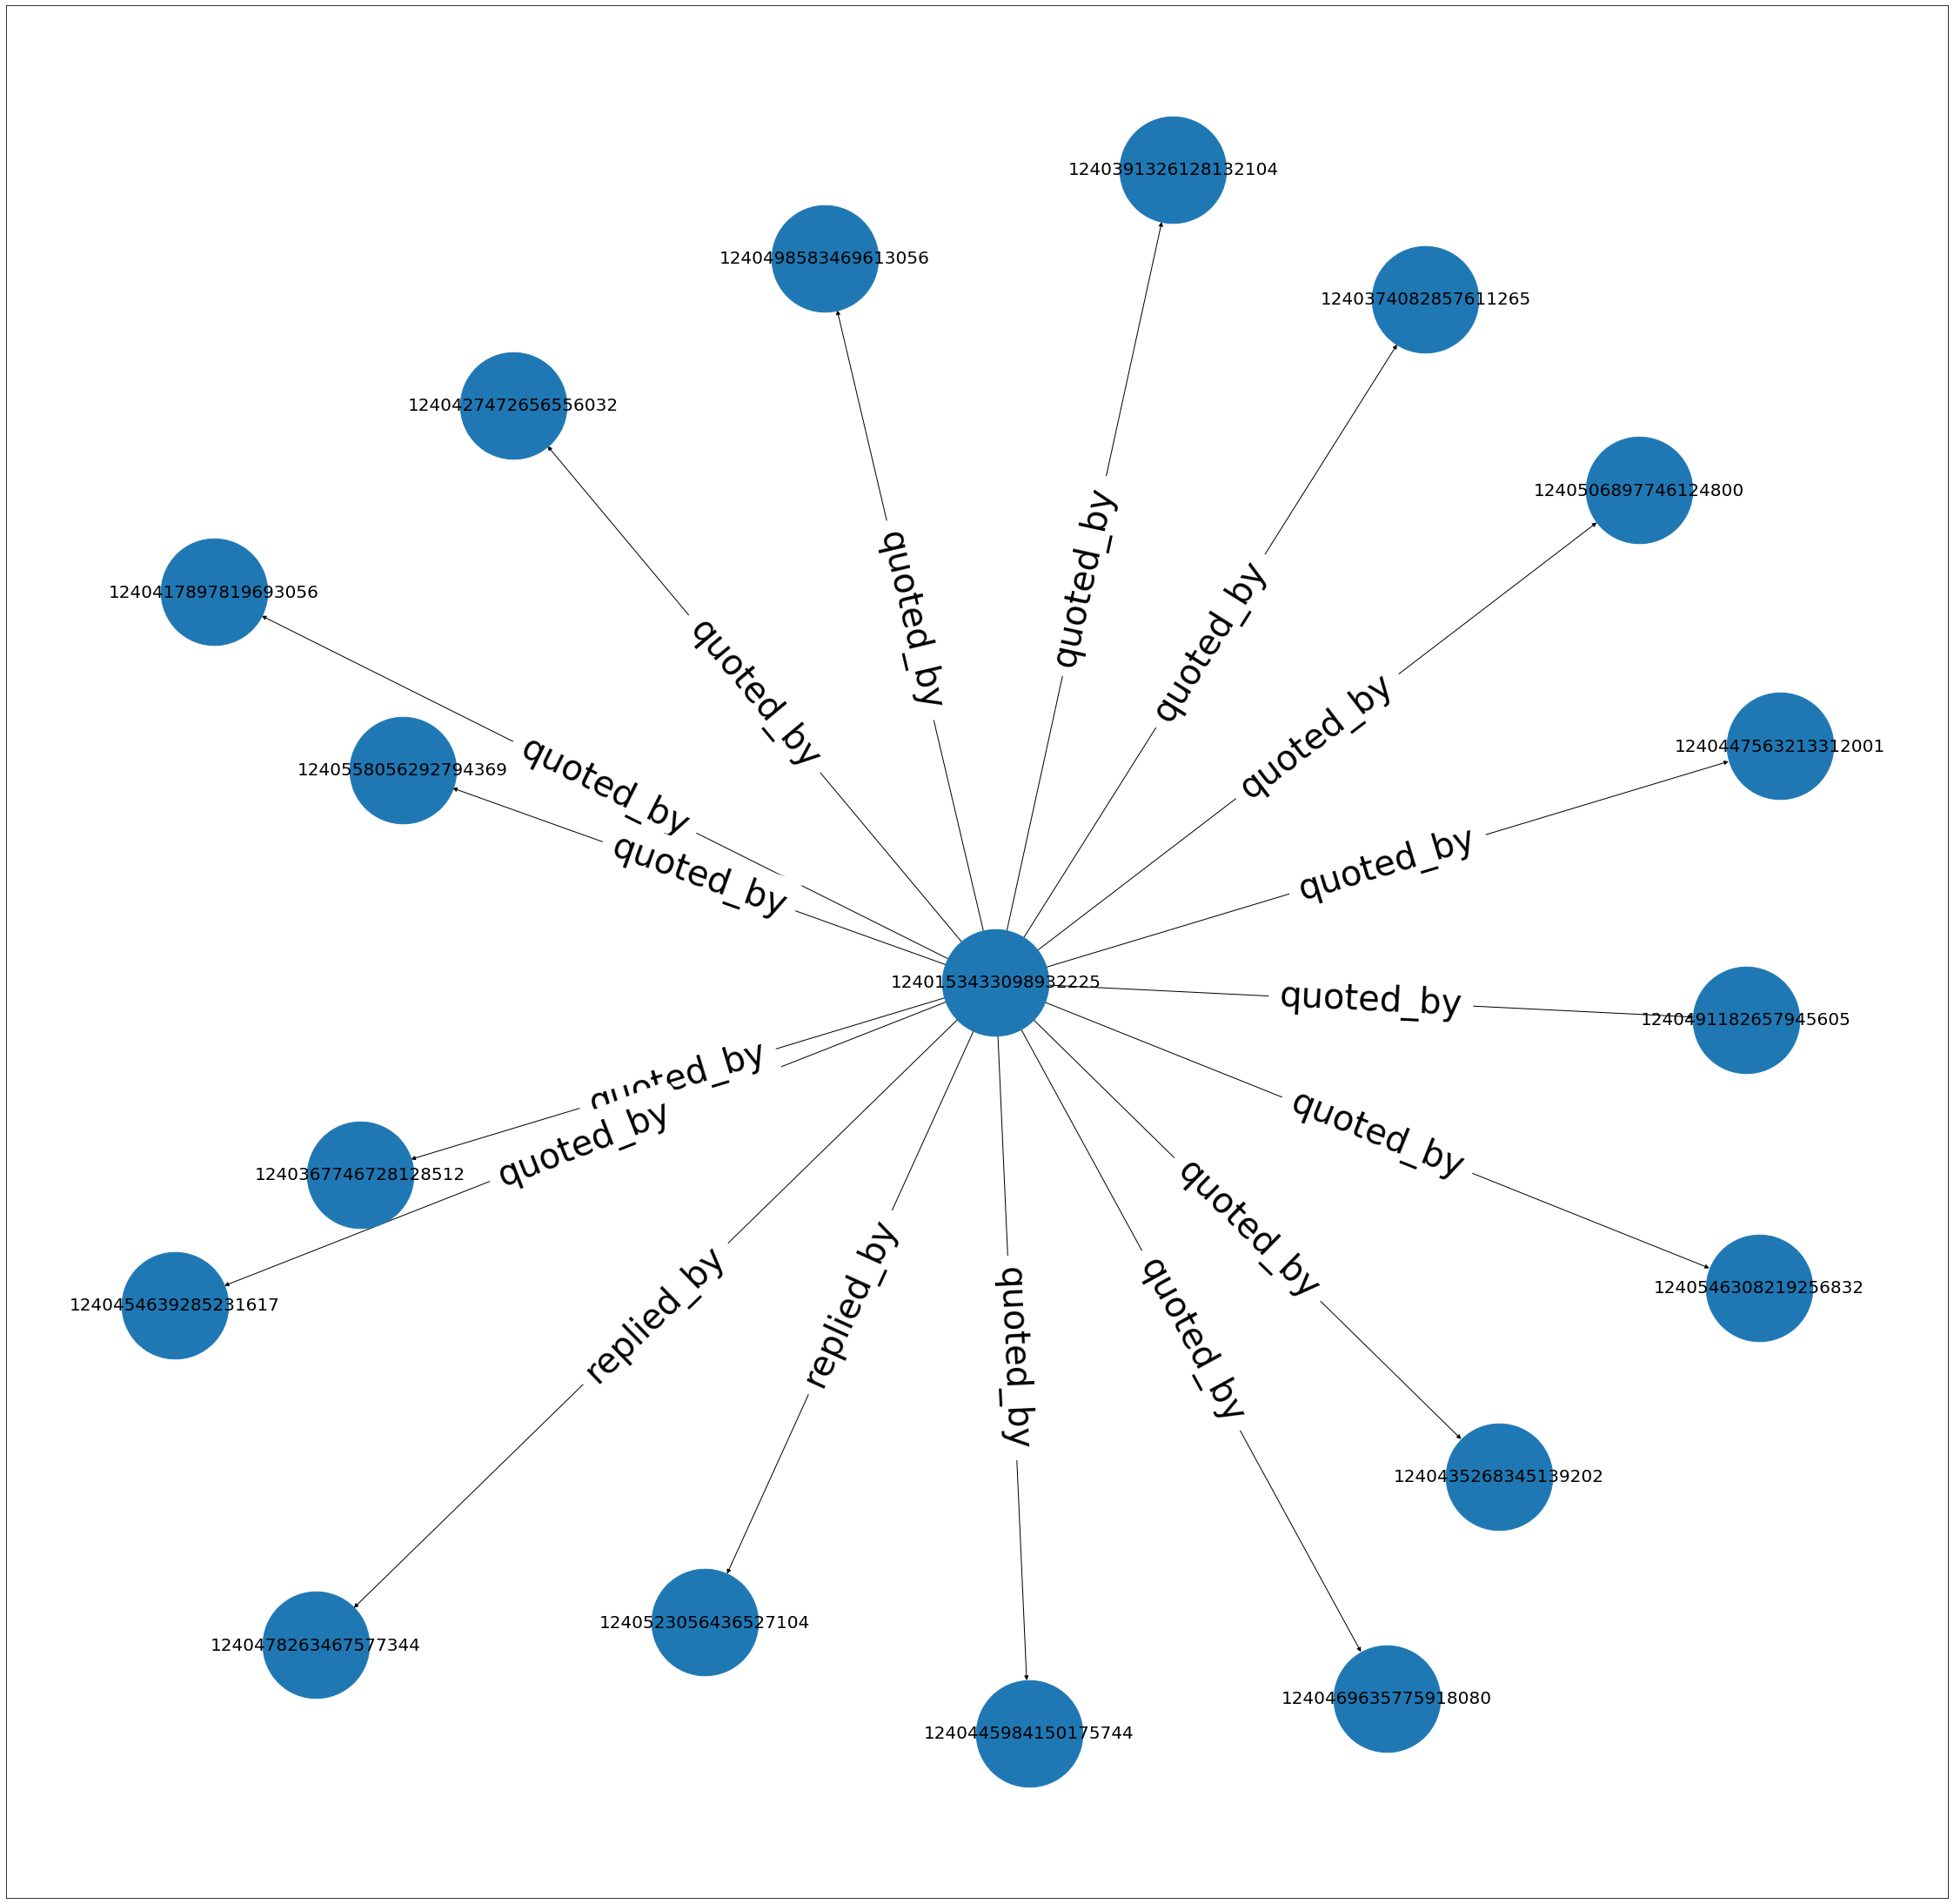

In [ ]:
# visualize subgraph(s)
# using print_subgraph function to print the subgraphs rooted by tweets that are from n1-th to n2-th popular among all tweets

import matplotlib.pyplot as plt
import networkx as nx
def print_subgraph_helper(G: graph, G2:nx.graph, root: int, edgelabels: dict) -> None:
    if (not root):
        return
    q = "select ?tweet where { '" + str(root)+"'  <http://UCLA_REU_2021_KG.org/test/replied_by> ?tweet }" 
    list_of_nodes_reply = convert_to_list_of_answer(G.query(q))
    for node in list_of_nodes_reply:
        G2.add_edge(root, node[0])
        edgelabels[(root, node[0])] = "replied_by"

    q = "select ?tweet where {'" + str(root)+"\'  <http://UCLA_REU_2021_KG.org/test/quoted_by> ?tweet }" 
    list_of_nodes_quote = convert_to_list_of_answer(G.query(q))
    for node in list_of_nodes_quote:
        G2.add_edge(root, node[0])
        edgelabels[(root, node[0])] = "quoted_by"

    list_of_nodes = list_of_nodes_reply + list_of_nodes_quote
    #print(list_of_nodes)
    for node in list_of_nodes:
        print_subgraph_helper(G, G2, node[0], edgelabels)

  
    
    
def print_subgraph(G: graph, n1: int, n2:int, ordered_list_of_nodes: list) -> None:
    """
    Given an ordered list of tweets where all tweets are ordered by their popularity (sum of quote_count and replies_count), 
    and print the subgraph rooted by tweets that are from n1-th to n2-th popular among all tweets, 
    i.e. all tweets replying to and quoting from those tweets are also shown in the visualization.
    """
    subgraph = nx.DiGraph()
    edge_labels={}
    for i in range(n1, n2+1):
        node = ordered_list_of_nodes[i]
        print_subgraph_helper(G, subgraph, node, edge_labels)
        # print out the text of popular tweets
        #print(i,"th(st/nd/rd) popular tweet, tweet ID: ", node, "text: ", ordered_list[i]["text"])
    

    %matplotlib inline
    """
    change figsize to modify how big the visualization of our KG is 
    """
    plt.figure(figsize=(40,40))

    """
    k controls the distance between the nodes and varies between 0 and 1
    iterations is the number of times simulated annealing is run
    default k=0.1 and iterations=50
    """
    layout = nx.spring_layout(subgraph,k=0.1,iterations=30)

    nx.draw_networkx(subgraph, pos=layout,font_size=20,node_size=15000) #,node_color=color_map
    nx.draw_networkx_edge_labels(subgraph, pos=layout, edge_labels=edge_labels, font_size=40)

    outputFileName = '/content/drive/My Drive/UCLA REU 2021 KG /GraphQuery/graphquery/Cluster.png'
    plt.savefig(outputFileName)
    plt.show()
    

# an example of plotting subgraphs rooted by first 8 most popular tweets
#print_subgraph(graph, 0,15, ordered_list_of_tweet_id)

print_subgraph(graph, 0, 0, ordered_list_of_tweet_id)

In [ ]:
# analyze sentiment changes through a thread, given a root



# a simple example of sentiment change analysis

central_tweet = "1241463311457107968"#'1240342359264489472'#"1240176626450587648"
#find tweets replies to tweet 1240416235671572480
#1240310641681821696
global counter
counter = 1
def sentiment_change(graph, root_tweetID,sentiment_flow=[]):
    q = "select ?score  where { '"+str(root_tweetID)+"' <http://UCLA_REU_2021_KG.org/test/sentimentScore> ?score}"
    print(q)
    print(convert_to_list_of_answer(graph.query(q)))
    if convert_to_list_of_answer(graph.query(q)):
        
        sentiment_flow.append(float(convert_to_list_of_answer(graph.query(q))[0][0]))
    q = "select ?tweet where { '" + str(root_tweetID)+"'  <http://UCLA_REU_2021_KG.org/test/replied_by> ?tweet }" 
    result2 = convert_to_list_of_answer(graph.query(q))
    q = "select ?tweet where { '" + str(root_tweetID)+"'  <http://UCLA_REU_2021_KG.org/test/quoted_by> ?tweet }"
    result = convert_to_list_of_answer(graph.query(q))
 
    result += result2
    if (result == []):
        x = list(range(len(sentiment_flow)))
        global counter
        plt.plot(x, sentiment_flow,label="tweet flow "+str(counter))
        
        print(counter)
        return
    print(sentiment_flow,'\n')
    
    for tweet in result:
        counter+=1
        sentiment_change(graph, tweet[0], list(sentiment_flow))
            
sentiment_change(graph, central_tweet,sentiment_flow=[])


  
# naming the x axis
plt.xlabel('time')
# naming the y axis
plt.ylabel('sentiment score')
  
# giving a title to my graph
plt.title('central tweet: '+ str(central_tweet))
plt.legend()
plt.ylim(-1,1)
plt.xlim(0,10)

# function to show the plot
plt.show()



select ?score  where { '1241463311457107968' <http://UCLA_REU_2021_KG.org/test/sentimentScore> ?score}
[]
[] 

select ?score  where { '1241466302398484481' <http://UCLA_REU_2021_KG.org/test/sentimentScore> ?score}
[]


NameError: ignored

1241440300167380992 None When you find a bottle of hand sanitizer in your trunk 
https://t.co/FN8bHX8HRn
1241440497081536512 None When the president changes his mind about the virus 
https://t.co/HuVaLDcr2p
1241440741605249024 None When you find out Tito's Taco is open for pick up
https://t.co/k2BJwRI7bT
1241440976150736896 None Where you are spending the next two months 
https://t.co/k2BJwRI7bT
1241441133261025280 None When you start an only fans 
https://t.co/8QsaqsdobM
1241441297690312704 None When you check your 401k
https://t.co/z2braYY5oo
1241441644743778304 None When Costco runs out of paper towels 
https://t.co/Zsw8brysua
1241441873073328128 None When you and the person you started dating a week ago both get laid off 
https://t.co/FTQnITHWO5
1241442107333554176 None When you calculate your new monthly budget
https://t.co/VAf83p7rqK
1241442290159116288 None Where you end up after you spring break in Florida
https://t.co/Hr4g3avWmK
1241442594556481536 None When you find that 2 mo

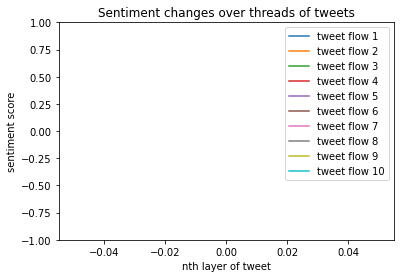

In [ ]:
# analyze sentiment changes given a json file of list of paths (paths.json)

import matplotlib.pyplot as plt
textDict = {str(tweet['tweet-id']):tweet['text'] for tweet in jsons}

def findTextById(id):
  id = str(id)
  if id in textDict:
    txt = textDict[id]
    return txt if txt else 'TEXT_IS_NONE'
  else:
    return 'NOT_IN_DATASET'

def printPath(p):
  
  return([str(findTextById(id)) for id in p])

def sentiment_change_given_a_path(graph, list_of_ID,sentiment_flow=[]):
  for i in list_of_ID:
    q = "select ?score  where { '"+str(i)+"' <http://UCLA_REU_2021_KG.org/test/sentimentScore> ?score}"
    answer = convert_to_list_of_answer(graph.query(q))
    if answer:
      sentiment_flow.append(float(answer[0][0]))
    else:
      sentiment_flow.append(None)



def sentiment_change_given_paths(graph):
  num_of_paths = 1
  with open(fullPath('paths_strict2.json')) as file:
    for path_list in file:
      if num_of_paths > 10: return
      path_list = path_list[2:-3].split("\', \'")


      sentiment_flow = []
      sentiment_change_given_a_path(graph, path_list,sentiment_flow)
      text = printPath(path_list)
      for i in range(len(sentiment_flow)):
        print((path_list)[i], sentiment_flow[i], text[i] )
      print("---------------------END OF TWEETS FLOW {}---------------------".format(num_of_paths))
      plt.plot(range(len(sentiment_flow)), sentiment_flow,label="tweet flow "+str(num_of_paths))
      num_of_paths += 1
sentiment_change_given_paths(graph)




# naming the x axis
plt.xlabel('nth layer of tweet')
# naming the y axis
plt.ylabel('sentiment score')
  
# giving a title to my graph
plt.title('Sentiment changes over threads of tweets')
plt.legend()
plt.ylim(-1,1)
#plt.xlim(0,15)

# function to show the plot
plt.show()



432 defaultdict(<class 'list'>, {'Mar 01 00': [], 'Mar 01 01': [], 'Mar 01 02': [], 'Mar 01 03': [], 'Mar 01 04': [], 'Mar 01 05': [], 'Mar 01 06': [], 'Mar 01 07': [], 'Mar 01 08': [], 'Mar 01 09': [], 'Mar 01 10': [], 'Mar 01 11': [], 'Mar 01 12': [], 'Mar 01 13': [], 'Mar 01 14': [], 'Mar 01 15': [], 'Mar 01 16': [], 'Mar 01 17': [], 'Mar 01 18': [], 'Mar 01 19': [], 'Mar 01 20': [], 'Mar 01 21': [], 'Mar 01 22': [], 'Mar 01 23': [], 'Mar 02 00': [], 'Mar 02 01': [], 'Mar 02 02': [], 'Mar 02 03': [], 'Mar 02 04': [], 'Mar 02 05': [], 'Mar 02 06': [], 'Mar 02 07': [], 'Mar 02 08': [], 'Mar 02 09': [], 'Mar 02 10': [], 'Mar 02 11': [], 'Mar 02 12': [], 'Mar 02 13': [], 'Mar 02 14': [], 'Mar 02 15': [], 'Mar 02 16': [], 'Mar 02 17': [], 'Mar 02 18': [], 'Mar 02 19': [], 'Mar 02 20': [], 'Mar 02 21': [], 'Mar 02 22': [], 'Mar 02 23': [], 'Mar 03 00': [], 'Mar 03 01': [], 'Mar 03 02': [], 'Mar 03 03': [], 'Mar 03 04': [], 'Mar 03 05': [], 'Mar 03 06': [], 'Mar 03 07': [], 'Mar 03 08': []

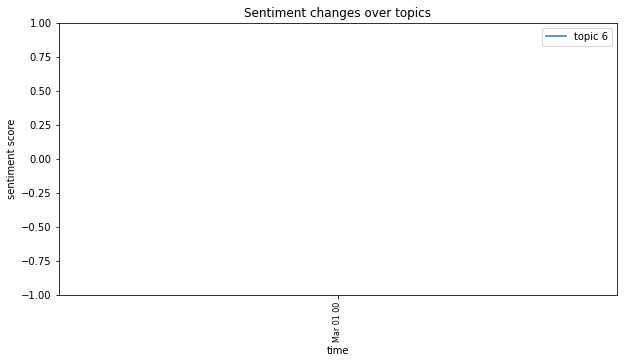

In [ ]:
# analyze sentiment changes given a specific LDA Topic
import matplotlib.pyplot as plt
from collections import defaultdict
MONTH_ORDER = {"Jan": 0, "Feb": 1, "Mar": 2, "Apr": 3, "May": 4, "Jun": 5, "Jul": 6, "Aug": 7, "Sep": 8, "Oct": 9, "Nov": 10, "Dec": 11}

def sentiment_change_given_a_topic(graph, topic: int):
    global sentiment
    sentiment = defaultdict(list)
  
    for i in range(1,19):
      if len(str(i))== 1: i = '0'+str(i)
      for j in range(0, 24):
        if len(str(j))== 1: j = '0'+str(j)
        sentiment["Mar "+str(i)+' '+ str(j)]=[]
    """
    for i in range(1, 17):
      for j in range(0, 24):
        if len(str(j))== 1: j = '0'+str(j)
        sentiment["Apr "+str(i)+' '+ str(j)]=[]
  """
    q = "select ?tweet where { ?tweet <http://UCLA_REU_2021_KG.org/test/Topic> '"+ str(topic)+"'}"
    answer = convert_to_list_of_answer(graph.query(q))
    if not answer or answer == [[]]: return 
    for ans in answer:
      if not ans: continue
      sentimentscore = convert_to_list_of_answer(graph.query("select ?score  where { '"+str(ans[0])+"' <http://UCLA_REU_2021_KG.org/test/sentimentScore> ?score}"))
      timestamp = convert_to_list_of_answer(graph.query("select ?time  where { '"+str(ans[0])+"' <http://UCLA_REU_2021_KG.org/test/timestamp> ?time}"))
      
      if sentimentscore and (timestamp) and (timestamp[0][0][4:10] in sentiment):
        sentiment[timestamp[0][0][4:10]].append(float(sentimentscore[0][0]))

      #if sentimentscore and (timestamp[0][0][4:13] in ['Mar 24 08','Mar 24 09','Mar 24 10','Mar 24 11','Mar 24 12','Mar 24 13','Mar 25 11','Mar 25 12','Mar 25 13','Mar 25 14' ]):
        #print(timestamp[0][0], findTextById(ans[0]))

    return sentiment


def sentiment_change_given_topics(graph):
  plt.figure(figsize=(10,5))

  for i in [6,]:
      sentiment = sentiment_change_given_a_topic(graph, i)
      print(len(sentiment), sentiment)
      sorted_dates = sorted(list(sentiment.keys()), key=lambda x: (MONTH_ORDER[x[0:3]], x[4:6]))

      plt.plot(sorted_dates , [sum(sentiment[key])/len(sentiment[key]) if len(sentiment[key]) > 0 else None for key in sorted_dates ],label="topic "+str(i))

#experiment
sentiment_change_given_topics(graph)



# naming the x axis
plt.xlabel('time')
# naming the y axis
plt.ylabel('sentiment score')
  
# giving a title to my graph
plt.title('Sentiment changes over topics')
plt.legend()
plt.ylim(-1,1)
plt.tick_params(axis = 'x',which = 'major', labelsize = 8, rotation = 90)
plt.savefig("/content/drive/My Drive/UCLA REU 2021 KG /GraphQuery/graphquery/Mar01_19_topic6_version.png")


# function to show the plot
plt.show()



In [ ]:
import pandas as pd
import os,csv

def dictToCsv(d:list,filename:str,rows=None):
  os.makedirs(os.path.dirname(filename), exist_ok=True)
  with open(fullPath(filename), 'w') as f:  
    w = csv.DictWriter(f, rows if rows else (d[0].keys()),extrasaction='ignore')
    w.writeheader()
    for dct in d:
      w.writerow(dct)

dictToCsv([])

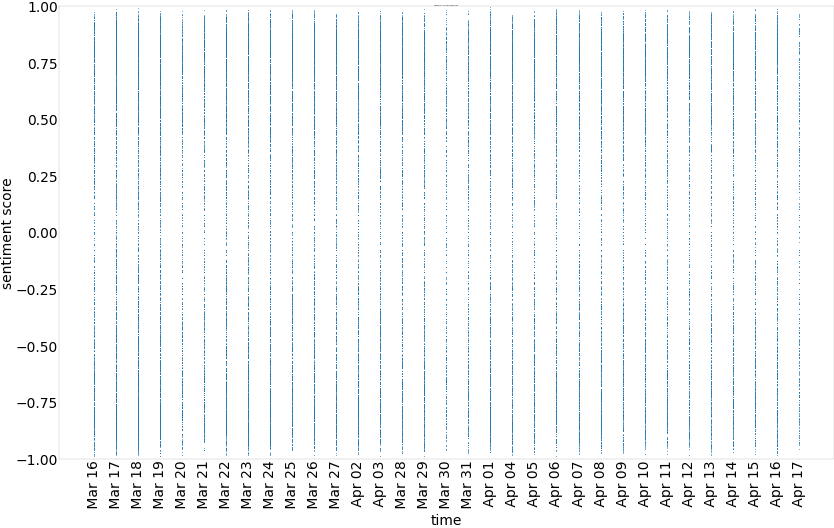

In [ ]:
# scatter plot of sentiments

from datetime import datetime
time = []
sentiment = []
for tweet in jsons:
  if tweet['keywords'] == []: continue 
  #timestamp = datetime.utcfromtimestamp(int(tweet["timestamp"])/1000)
  time.append(tweet['timestamp'][3:10])#str(timestamp.year)+str(timestamp.month)+str(timestamp.day)str(timestamp.hour))
  sentiment.append(tweet["sentiment_score"])
plt.figure(figsize=(100,60),dpi = 10)
plt.scatter(time, sentiment, alpha = 0.8)

  
# giving a title to my graph
plt.title('sentiment changes over time')
#plt.legend()
plt.ylim(-1,1)
#plt.xlim(0,10000)
plt.xlabel('time', fontsize = 100)
# naming the y axis
plt.ylabel('sentiment score',fontsize = 100)
plt.tick_params(axis = 'x',which = 'major', labelsize = 100, rotation = 90)
plt.tick_params(axis = 'y',which = 'major', labelsize = 100)

plt.show()

No handles with labels found to put in legend.


['Mar 16', 'Mar 17', 'Mar 18', 'Mar 19', 'Mar 20', 'Mar 21', 'Mar 22', 'Mar 23', 'Mar 24', 'Mar 25', 'Mar 26', 'Mar 27', 'Apr 02', 'Apr 03', 'Mar 28', 'Mar 29', 'Mar 30', 'Mar 31', 'Apr 01', 'Apr 04', 'Apr 05', 'Apr 06', 'Apr 07', 'Apr 08', 'Apr 09', 'Apr 10', 'Apr 11', 'Apr 12', 'Apr 13', 'Apr 14', 'Apr 15', 'Apr 16', 'Apr 17']


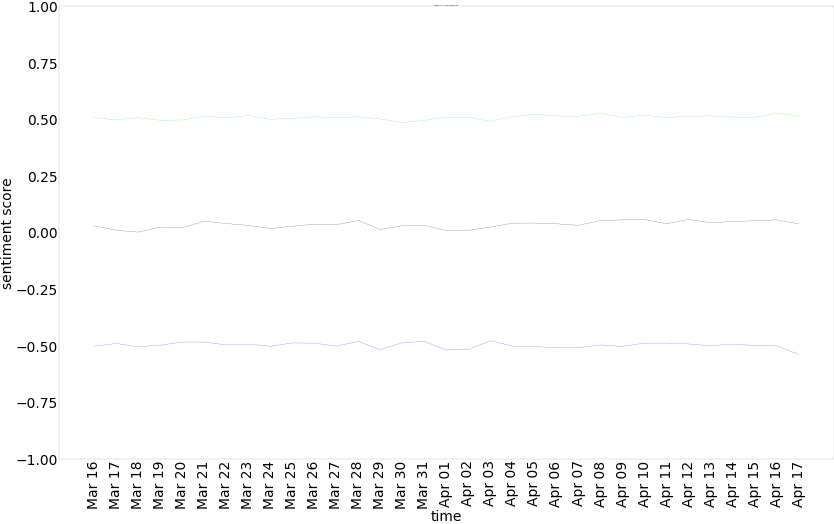

In [ ]:
# scatter plot of average sentiments
from collections import defaultdict
from datetime import datetime
MONTH_ORDER = {"Jan": 0, "Feb": 1, "Mar": 2, "Apr": 3, "May": 4, "Jun": 5, "Jul": 6, "Aug": 7, "Sep": 8, "Oct": 9, "Nov": 10, "Dec": 11}
sentiment = defaultdict(list)
for tweet in jsons:
  if tweet['keywords'] == []: continue 
  sentiment[tweet['timestamp'][4:10]].append(tweet["sentiment_score"])
plt.figure(figsize=(100,60),dpi = 10)
sorted_dates = sorted(list(sentiment.keys()), key=lambda x: (MONTH_ORDER[x[0:3]], x[4:6]))
print(list(sentiment.keys()))
#plt.plot(list(sentiment.keys()), [sum(sentiment[key])/len(sentiment[key]) for key in sentiment], alpha = 0.8, color = (0,0,0))
plt.plot(sorted_dates, [sum(sentiment[key])/len(sentiment[key]) for key in sorted_dates], alpha = 0.8, color = (0,0,0))
plt.plot(sorted_dates, [sum([i for i in sentiment[key] if (i > 0)  ])/len([i for i in sentiment[key] if (i > 0)  ]) for key in sorted_dates], alpha = 0.8, color = (0,1,0))
plt.plot(sorted_dates, [sum([i for i in sentiment[key] if (i < 0)  ])/len([i for i in sentiment[key] if (i < 0)  ]) for key in sorted_dates], alpha = 0.8, color = (0,0,1))

# giving a title to my graph
plt.title('sentiment changes over time')
plt.legend()
plt.ylim(-1,1)
#plt.xlim(0,10000)
plt.xlabel('time', fontsize = 100)
# naming the y axis
plt.ylabel('sentiment score',fontsize = 100)
plt.tick_params(axis = 'x',which = 'major', labelsize = 100, rotation = 90)
plt.tick_params(axis = 'y',which = 'major', labelsize = 100)

plt.show()

48 defaultdict(<class 'list'>, {'Mar 16 00': [], 'Mar 16 01': [], 'Mar 16 02': [], 'Mar 16 03': [], 'Mar 16 04': [], 'Mar 16 05': [], 'Mar 16 06': [], 'Mar 16 07': [0.6705, 0.8439, -0.6828], 'Mar 16 08': [], 'Mar 16 09': [], 'Mar 16 10': [], 'Mar 16 11': [], 'Mar 16 12': [], 'Mar 16 13': [], 'Mar 16 14': [], 'Mar 16 15': [], 'Mar 16 16': [], 'Mar 16 17': [], 'Mar 16 18': [], 'Mar 16 19': [], 'Mar 16 20': [], 'Mar 16 21': [], 'Mar 16 22': [], 'Mar 16 23': [], 'Mar 17 00': [], 'Mar 17 01': [], 'Mar 17 02': [], 'Mar 17 03': [], 'Mar 17 04': [], 'Mar 17 05': [], 'Mar 17 06': [], 'Mar 17 07': [], 'Mar 17 08': [], 'Mar 17 09': [], 'Mar 17 10': [], 'Mar 17 11': [], 'Mar 17 12': [], 'Mar 17 13': [], 'Mar 17 14': [], 'Mar 17 15': [], 'Mar 17 16': [], 'Mar 17 17': [], 'Mar 17 18': [], 'Mar 17 19': [], 'Mar 17 20': [], 'Mar 17 21': [], 'Mar 17 22': [-0.0516], 'Mar 17 23': []})


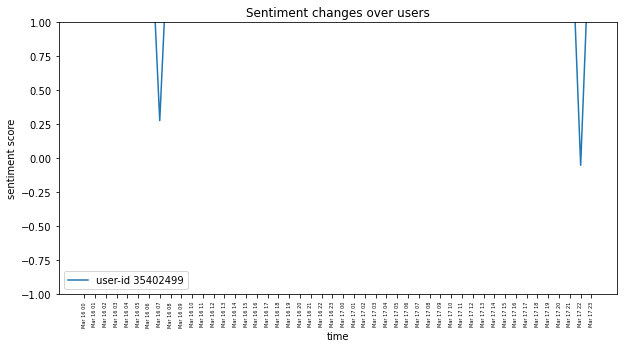

In [ ]:
#sentiment change for given user
import matplotlib.pyplot as plt
from collections import defaultdict
MONTH_ORDER = {"Jan": 0, "Feb": 1, "Mar": 2, "Apr": 3, "May": 4, "Jun": 5, "Jul": 6, "Aug": 7, "Sep": 8, "Oct": 9, "Nov": 10, "Dec": 11}

def sentiment_change_given_a_user(graph, user: int):
    sentiment = defaultdict(list)
    for i in range(16, 18):
      for j in range(0, 24):
        if len(str(j))== 1: j = '0'+str(j)
        sentiment["Mar "+str(i)+' '+ str(j)]=[]
        """
    for i in range(1, 17):
      for j in range(0, 24):
        if len(str(j))== 1: j = '0'+str(j)
        sentiment["Apr "+str(i)+' '+ str(j)]=[]
        """
    q = "select ?tweet where { ?tweet <http://UCLA_REU_2021_KG.org/test/Tweeted_By> '"+ str(user)+"'}"
    answer = convert_to_list_of_answer(graph.query(q))
    if not answer or answer == [[]]: return 
    for ans in answer:
      if not ans: continue
      sentimentscore = convert_to_list_of_answer(graph.query("select ?score  where { '"+str(ans[0])+"' <http://UCLA_REU_2021_KG.org/test/sentimentScore> ?score}"))
      timestamp = convert_to_list_of_answer(graph.query("select ?time  where { '"+str(ans[0])+"' <http://UCLA_REU_2021_KG.org/test/timestamp> ?time}"))
      if sentimentscore and (timestamp[0][0][4:13] in sentiment):
        sentiment[timestamp[0][0][4:13]].append(float(sentimentscore[0][0]))
    return sentiment


def sentiment_change_given_users(graph):
  plt.figure(figsize=(10,5))
  user_ids_to_examine = [35402499]
  for i in user_ids_to_examine:
      sentiment = sentiment_change_given_a_user(graph, i)
      print(len(sentiment), sentiment)
      sorted_dates = sorted(list(sentiment.keys()), key=lambda x: (MONTH_ORDER[x[0:3]], x[4:6]))

      plt.plot(sorted_dates , [sum(sentiment[key])/len(sentiment[key]) if len(sentiment[key]) > 0 else 2 for key in sorted_dates ],label="user-id "+str(i))

#experiment
sentiment_change_given_users(graph)




# naming the x axis
plt.xlabel('time')
# naming the y axis
plt.ylabel('sentiment score')
  
# giving a title to my graph
plt.title('Sentiment changes over users')
plt.legend()
plt.ylim(-1,1)
plt.tick_params(axis = 'x',which = 'major', labelsize = 5, rotation = 90)


# function to show the plot
plt.show()

In [ ]:
# keyword change over a thread (incomplete)


   


In [ ]:
# visualize subgraph(s) with keywords
# using print_subgraph function to print the subgraphs rooted by tweets that are from n1-th to n2-th popular among all tweets

import matplotlib.pyplot as plt
import networkx as nx
def print_subgraph_helper(G: graph, G2:nx.graph, root: int, edgelabels: dict) -> None:
    if (not root):
        return
    q = "select ?tweet where { '" + str(root)+"'  <http://UCLA_REU_2021_KG.org/test/replied_by> ?tweet }" 
    list_of_nodes_reply = convert_to_list_of_answer(G.query(q))
    for node in list_of_nodes_reply:
        G2.add_edge(root, node[0])
        edgelabels[(root, node[0])] = "replied_by"

    q = "select ?tweet where {'" + str(root)+"\'  <http://UCLA_REU_2021_KG.org/test/quoted_by> ?tweet }" 
    list_of_nodes_quote = convert_to_list_of_answer(G.query(q))
    for node in list_of_nodes_quote:
        G2.add_edge(root, node[0])
        edgelabels[(root, node[0])] = "quoted_by"

    q = "select ?keyword where {'" + str(root)+"\'  <http://UCLA_REU_2021_KG.org/test/has_keyword> ?keyword }" 
    list_of_keywords = convert_to_list_of_answer(G.query(q))
    for keyword in list_of_keywords:
        G2.add_edge(root, keyword[0])
        edgelabels[(root, keyword[0])] = "has_keyword"
    list_of_nodes = list_of_nodes_reply + list_of_nodes_quote
    #print(list_of_nodes)
    for node in list_of_nodes:
        print_subgraph_helper(G, G2, node[0], edgelabels)

  
    
    
def print_subgraph(G: graph, n1: int, n2:int, ordered_list_of_nodes: list, name) -> None:
    """
    Given an ordered list of tweets where all tweets are ordered by their popularity (sum of quote_count and replies_count), 
    and print the subgraph rooted by tweets that are from n1-th to n2-th popular among all tweets, 
    i.e. all tweets replying to and quoting from those tweets are also shown in the visualization.
    """
    subgraph = nx.Graph()
    edge_labels={}
    for i in range(n1, n2+1):
        node = ordered_list_of_nodes[i]
        print_subgraph_helper(G, subgraph, node, edge_labels)
        # print out the text of popular tweets
        #print(i,"th(st/nd/rd) popular tweet, tweet ID: ", node, "text: ", ordered_list[i]["text"])
    
    color_map = []
    for node in subgraph:
      if (node.isdigit()) and (len(str(node)) == 19): # distinguish between Tweets (numerical id) and keywords (string)
        color_map.append('cyan')
      else:
        color_map.append('magenta')
    %matplotlib inline
    """
    change figsize to modify how big the visualization of our KG is 
    """
    plt.figure(figsize=(40,40))

    """
    k controls the distance between the nodes and varies between 0 and 1
    iterations is the number of times simulated annealing is run
    default k=0.1 and iterations=50
    """
    layout = nx.spring_layout(subgraph,k=0.15,iterations=30)

    nx.draw_networkx(subgraph, pos=layout,font_size=20,node_size=9000,node_color=color_map)
    nx.draw_networkx_edge_labels(subgraph, pos=layout, edge_labels=edge_labels, font_size=20)

    outputFileName = '/content/drive/My Drive/UCLA REU 2021 KG /GraphQuery/graphquery/'+name
    plt.savefig(outputFileName)
    plt.show()
    

# an example of plotting subgraphs rooted by first 8 most popular tweets
#print_subgraph(graph, 0,15, ordered_list_of_tweet_id)

print_subgraph(graph, 0, 0, ordered_list_of_tweet_id,'subgraph_keywords.png')


NameError: ignored

In [ ]:
from datetime import datetime
tstamp = 1584342002000
utcdttime = datetime.utcfromtimestamp(tstamp/1000)
print(str(utcdttime.month))



3


False